<a href="https://colab.research.google.com/github/ttcielott/bulldozar_price_prediction/blob/main/tabular_bulldozar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1> Price Prediction: Bulldozar Price </h1>

Using the tabular dataset of bulldozar features and prices, I will generate a prediction model on the price of a bulldozar. If you click [this link](https://huggingface.co/spaces/Dana19/bulldozar_price_predictor), you can select the features of bulldozar and get the expected price! This technique can be applied to establishing price strategy for any commercial goods and services and decision on stock investment. 


<img src = "https://images.freeimages.com/images/large-previews/51d/building-machine-1422763.jpg" width = 500></img>

# Final Product : [Price Predictor](https://huggingface.co/spaces/Dana19/bulldozar_price_predictor)
</center>

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from sklearn.metrics import mean_squared_error


pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Mounted at /content/gdrive


# Connect to Kaggle to fetch dataset

In [ ]:
creds = '{"username":"cielokim","key":"b45ea1142ece82d62dce84a7648d4a00"}'

In [ ]:
# create it based on my credential
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: argument command: invalid choice: 'dataset' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'config')


In [ ]:
# download dataset

from kaggle import api

if not path.exists():
  path.mkdir(parents = true)
  api.competition_download_cli(comp, path=path)
  shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type = 'text')

100%|██████████| 48.4M/48.4M [00:01<00:00, 37.8MB/s]


(#7) [Path('Machine_Appendix.csv'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('TrainAndValid.csv')]

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory = False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,...,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,...,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,...,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,...,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,...,NaN,NaN,NaN,NaN


In [ ]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [ ]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [ ]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

In [ ]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered = True, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


# Standardizing Data: Log Normalization

In [ ]:
# the dependent variable
dep_var = 'SalePrice'

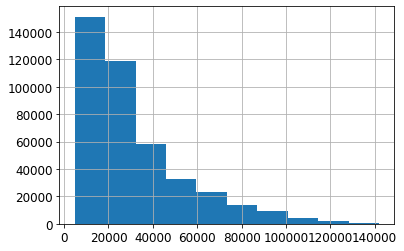

In [ ]:
df['SalePrice'].hist()
plt.show()

The distribution of the dependent variable (target variable) is right skewed, so let's change the scale to log.

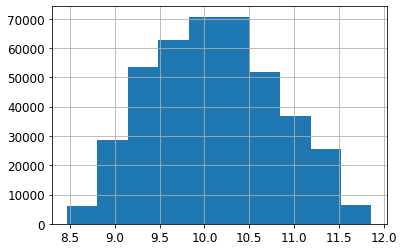

In [ ]:
np.log(df['SalePrice']).hist()
plt.show()

When producing output of price prediction, covert scale back to the original by applying exponential. 

Tip: how to explore columns quickly

In [ ]:
# how many data-related columns are there? (other than 'YearMade')
[f for f in df.columns if 'date' in f.lower()]

['saledate']

In [ ]:
df['SalePrice'] = np.log(df['SalePrice'])

In [ ]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [ ]:
df.loc[:, 'saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

# Feature engineering

**Tabular Core**

Basic function to preprocess tabular data before assembling it in a DataLoaders.
https://docs.fast.ai/tabular.core.html


Initial preprocessing

*   make_date
*   add_datepart
*   add_elapsed_times
*   df_shrink_dtypes
*   df_shrink
*   Tabular
*   TabularPandas
*   Categorify
*   FillStrategy
*   FillMissing
*   ReadTabBatch
*   TabDataLoader

## 1) Feature Extraction

convert column into datetime and extract as many features as possible.

In [ ]:
 df = add_datepart(df, 'saledate')

In [ ]:
# set pandas data frame show maximum 100 columns 
pd.options.display.max_columns = 100

In [ ]:
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,9.210340,1919201,21435,149,2.0,2005,NaN,NaN,30NX,30,NX,NaN,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2012,3,10,7,2,67,False,False,False,False,False,False,1.331078e+09
412694,6333345,9.259131,1882122,21436,149,2.0,2005,NaN,NaN,30NX2,30,NX,2,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons",Florida,TEX,Track Excavators,NaN,EROPS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,N

In [ ]:
df[[f for f in df.columns if 'sale' in f]]

,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,2006,11,46,16,3,320,False,False,False,False,False,False,1.163635e+09
1,2004,3,13,26,4,86,False,False,False,False,False,False,1.080259e+09
2,2004,2,9,26,3,57,False,False,False,False,False,False,1.077754e+09
3,2011,5,20,19,3,139,False,False,False,False,False,False,1.305763e+09
4,2009,7,30,23,3,204,False,False,False,False,False,False,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,2012,3,10,7,2,67,False,False,False,False,False,False,1.331078e+09
412694,2012,1,4,28,5,28,False,False,False,False,False,False,1.327709e+09
412695,2012,1,4,28,5,28,False,False,False,False,False,False,1.327709e+09
412696,2012,3,10,7,2,67,False,False,False,False,False,False,1.331078e+09


In [ ]:
# apply the same transformation to test dataset

df_test = pd.read_csv(path/'Test.csv', low_memory = False)
df_test = add_datepart(df_test, 'saledate')
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1227829,1006309,3168,121,3,1999,3688.0,Low,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,5,18,3,3,124,False,False,False,False,False,False,1.336003e+09
1,1227844,1022817,7271,121,3,1000,28555.0,High,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2012,5,19,10,3,131,False,False,False,False,False,False,1.336608e+09
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2012,5,19,10,3,131,False,False,False,False,False,False,1.336608e+09
3,1227848,56204,1269,121,3,2006,8940.0,High,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metric Tons",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN,2012,5,19,10,3,131,False,False,False,False,False,False,1.336608e+09
4,1227863,1053887,22312,121,3,2005,2286.0,Low,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,5,19,10,3,131,False,False,False,False,False,False,1.336608e+09


In [ ]:
''.join(o for o in df.columns if o.startswith('sale'))

'saleYearsaleMonthsaleWeeksaleDaysaleDayofweeksaleDayofyearsaleIs_month_endsaleIs_month_startsaleIs_quarter_endsaleIs_quarter_startsaleIs_year_endsaleIs_year_startsaleElapsed'

## 2) Type Casting and Handling Missing Data

-  Categorify
   + transform the categorical variables to something similar to pd.Categorical
-  FillMissing
   + fill in missing data

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
# split train dataset into train and validation dataset
cond = (df.saleYear < 2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

- cont_cat_split
  + find what category features and continuous features are

In [ ]:
cont, cat  = cont_cat_split(df, 1, dep_var = dep_var)

In [ ]:
help(cont_cat_split)

Help on function cont_cat_split in module fastai.tabular.core:

cont_cat_split(df, max_card=20, dep_var=None)
    Helper function that returns column names of cont and cat variables from given `df`.



In [ ]:
# view continuous features
cont

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'saleYear',
 'saleMonth',
 'saleWeek',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleElapsed']

In [ ]:
# view categorical features
cat

['UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start']

In [ ]:
df[cont].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   MachineID                 412698 non-null  int64  
 2   ModelID                   412698 non-null  int64  
 3   datasource                412698 non-null  int64  
 4   auctioneerID              392562 non-null  float64
 5   YearMade                  412698 non-null  int64  
 6   MachineHoursCurrentMeter  147504 non-null  float64
 7   saleYear                  412698 non-null  int64  
 8   saleMonth                 412698 non-null  int64  
 9   saleWeek                  412698 non-null  int64  
 10  saleDay                   412698 non-null  int64  
 11  saleDayofweek             412698 non-null  int64  
 12  saleDayofyear             412698 non-null  int64  
 13  saleElapsed               412698 non-null  f

In [ ]:
df[cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   UsageBand                73670 non-null   object  
 1   fiModelDesc              412698 non-null  object  
 2   fiBaseModel              412698 non-null  object  
 3   fiSecondaryDesc          271971 non-null  object  
 4   fiModelSeries            58667 non-null   object  
 5   fiModelDescriptor        74816 non-null   object  
 6   ProductSize              196093 non-null  category
 7   fiProductClassDesc       412698 non-null  object  
 8   state                    412698 non-null  object  
 9   ProductGroup             412698 non-null  object  
 10  ProductGroupDesc         412698 non-null  object  
 11  Drive_System             107087 non-null  object  
 12  Enclosure                412364 non-null  object  
 13  Forks                    197715 non-null  ob

## 3) Convert Features to Numerical Value & Train Test Split

**TabularPandas**

https://docs.fast.ai/tabular.core.html#tabularpandas


In [ ]:
# splits = list of train data index and test data index
to = TabularPandas(df, procs, cat, cont, y_names = dep_var, splits = splits)

In [ ]:
len(to.train), len(to.valid)

(404710, 7988)

In [ ]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


Categorical features aren't shown as numbers, but if you access items, you can see the data converted as numbers.

In [ ]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,98,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,1.077754e+09,1,1


In [ ]:
to['UsageBand'].head(3)

0    2
1    2
2    1
Name: UsageBand, dtype: int8

In [ ]:
# view classes 
print(to.classes['ProductSize'])
print(to.classes['Steering_Controls'])

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']
['#na#', 'Command Control', 'Conventional', 'Four Wheel Standard', 'No', 'Wheel']


## 4) Export preprocessed data

In [ ]:
# save preprocessed data
save_pickle(path/'to.pkl', to)

In [ ]:
# load prepreocessed data
to = load_pickle(path/'to.pkl')

# Modeling

## 1) DecisionTreeRegressor

In [ ]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [ ]:
model = DecisionTreeRegressor(max_leaf_nodes = 4)
model.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

As max_leaf_nodes is set as 4, the model will stop at 4.

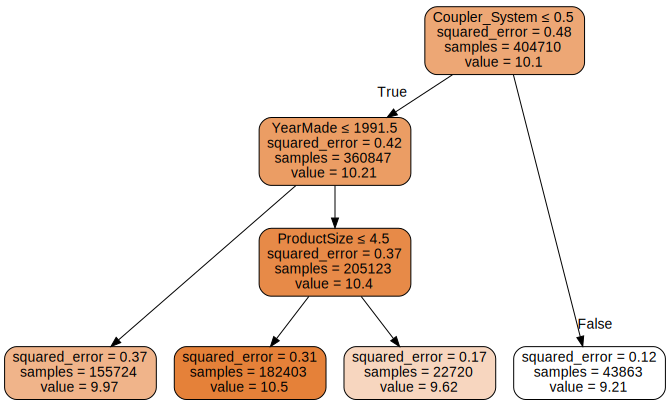

In [ ]:
draw_tree(model, xs, size = 10, leaves_parallel = True, precision = 2)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  "X does not have valid feature names, but"


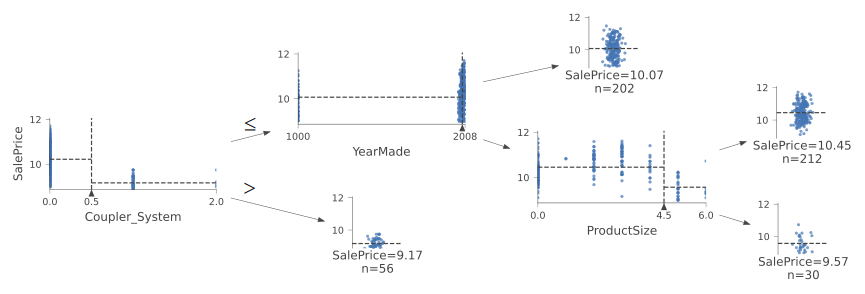

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(model, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, 
         fontname = 'DejaVu Sans', scale = 1.6, label_fontsize= 10, 
         orientation = 'LR')

In [ ]:
model = DecisionTreeRegressor()
model.fit(xs, y)

DecisionTreeRegressor()

In [ ]:
def rmse(model, xs, y):
  y_pred = model.predict(xs)
  mse = mean_squared_error(y, y_pred)
  return round(np.sqrt(mse), 6)

In [ ]:
rmse(model, valid_xs, valid_y)

0.332039

## 2) RandomForestRegressor

Random Forest selects feature columns at random and creates multiple independnent trees.

The random forest algorithm is an extension of the bagging method as it utilizes both bagging and feature randomness to create an uncorrelated forest of decision trees. Feature randomness, also known as feature bagging or “the random subspace method”, generates a random subset of features, which ensures low correlation among decision trees. This is a key difference between decision trees and random forests. While decision trees consider all the possible feature splits, random forests only select a subset of those features.


In [ ]:
def rf(xs, y, n_estimators = 40, max_samples = 200_000, 
       max_features = 0.5, min_samples_leaf = 5, **kwargs):
  return RandomForestRegressor(n_jobs = -1, n_estimators=n_estimators,
                               max_samples= max_samples, max_features = max_features,
                               min_samples_leaf = min_samples_leaf, oob_score = True).fit(xs, y)


In [ ]:
rf_model = rf(xs, y)

In [ ]:
rmse(rf_model, valid_xs, valid_y)

0.233348

In [ ]:
#| output: false
preds = np.stack([t.predict(valid_xs) for t in rf_model.estimators_])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature n

In [ ]:
preds.shape

(40, 7988)

In [ ]:
len(valid_xs)

7988

40 estimators made prediction on test set (valid_xs) which is totaled 7,988 data.

In [ ]:
len(preds.mean(0))

7988

In [ ]:
estimators_avg = preds.mean(0)
np.sqrt(mean_squared_error(valid_y, estimators_avg))

0.2333481180438798

More Estimators -> Better Accruacy 

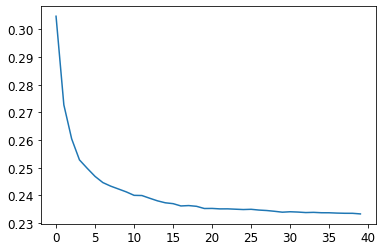

In [ ]:
plt.plot([np.sqrt(mean_squared_error(valid_y, preds[:i+1].mean(0))) \
          for i in range(40)])
plt.show()

# Model interpretation

Let's see what's going on inside the model

## 1) Standard Deviation of Prediction 

trees = estimators

In [ ]:
# calculate the standard deviation of 7988 predicted values of all 40 estimators.
preds_std = preds.std(0)
preds_std.shape

(7988,)

In [ ]:
# how much variation there was in predictions
# the lower std predictions have, the more agreed estimators 
# for first 5 predictions
preds_std[:5] 

array([0.25817049, 0.12401786, 0.09668753, 0.23126715, 0.12708752])

As you can see above, 40 estimators make predictions most closely on the third test data out of the first five test data.

## 2) Narrowing down features

Keeping only important features

#### feature_importances_

In [ ]:
len(rf_model.feature_importances_)

66

In [ ]:
len(xs.columns)

66

In [ ]:
def rf_feat_importance(m, df):
  return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}
                      ).sort_values('imp', ascending = False)

In [ ]:
fi = rf_feat_importance(rf_model, xs)
fi[:10]

,cols,imp
57,YearMade,0.181706
6,ProductSize,0.122101
30,Coupler_System,0.120868
7,fiProductClassDesc,0.066674
54,ModelID,0.058850
31,Grouser_Tracks,0.050997
65,saleElapsed,0.050438
3,fiSecondaryDesc,0.041468
32,Hydraulics_Flow,0.032451
1,fiModelDesc,0.031696


The most importance feature is YearMade, ProductSize, and Coupler_System in this order.

In [ ]:
# plot feature importance
def plot_fi(fi):
  return fi.plot('cols', 'imp', 'barh', figsize = (12,7), legend = False)


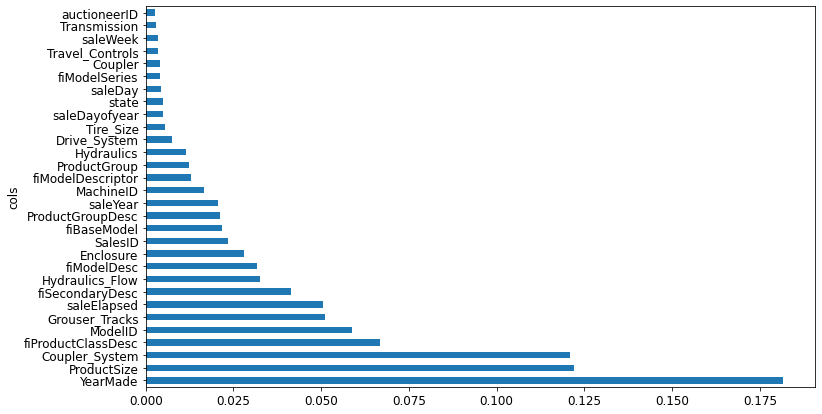

In [ ]:
# the 30 most import features
plot_fi(fi[:30])
plt.show()

You can keep only important features for modeling and exclude the others.

In [ ]:
# keep the features above 0.005
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

21

The number of features to keep is 21 in total.

In [ ]:
# select the features above from training and test set
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [ ]:
rf_model2 = rf(xs_imp, y)

In [ ]:
# veiw root mean squared error of training set and test set
print('model trained with all features: ',rmse(rf_model, xs, y), rmse(rf_model, valid_xs, valid_y))
print('model trained with important features (> 0.005): ',rmse(rf_model2, xs_imp, y), rmse(rf_model2, valid_xs_imp, valid_y))

model trained with all features:  0.171179 0.233348
model trained with important features (> 0.005):  0.181401 0.233


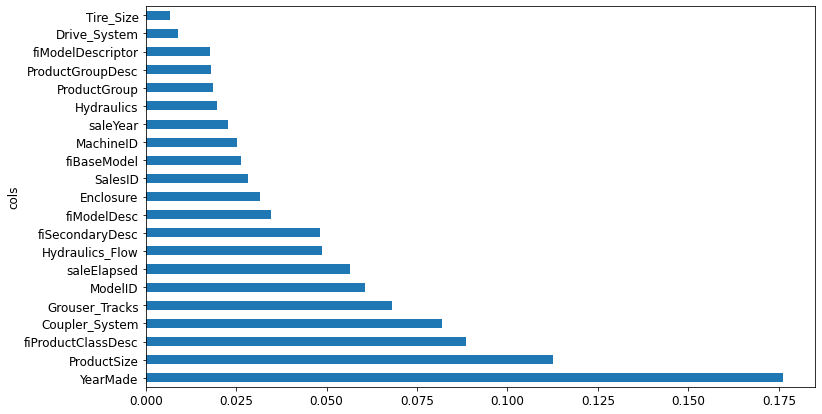

In [ ]:
# plot feature importance again
plot_fi(rf_feat_importance(rf_model2, xs_imp))
plt.show()

### Removing similar features

#### Hierarchical Clustering

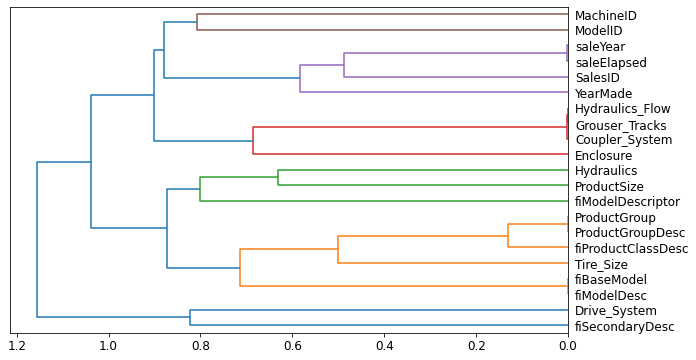

In [ ]:
# plot hierarchical clustering of the current features
cluster_columns(xs_imp)

In [ ]:
help(cluster_columns)

Help on function cluster_columns in module fastbook:

cluster_columns(df, figsize=(10, 6), font_size=12)



The closeness of features in the hierarchical clustering indicate similarity. 


*   e.g. 'saleYear' and 'saleElapsed' are very similar.

*   e.g. 'ProductGroup' and 'ProductGroupDesc' are very similar.




You can leave one among similar features and see what happens.

#### Out-of-bag score

The estimators or trees are to be trained with bootstrap samples. On average, for each tree, 63% of training data are sampled, but 37% are not sampled and constitutes the OOB instances. 

After modelings, you can have all trees predict target value with OOB instances and calculate how accurate the predictions were.

Note that in scikit-learn, the OOB score corresponds to accuracy score(= Jaccard score) for classifiers and R-squared for regressors. 

In [ ]:
def get_oob(df):
  m = RandomForestRegressor(n_estimators = 40, min_samples_leaf = 15,
                            max_samples= 50000, max_features = 0.5, n_jobs =-1, oob_score = True)
  m.fit(df, y)
  return m.oob_score_

In [ ]:
# get oob score you can get when modeling with xs_imp data
oob_imp = get_oob(xs_imp)
oob_imp

0.8774838816831307

In [ ]:
# get oob score you can get when modeling with xs_imp data of which a specific column is excluded
{c: get_oob(xs_imp.drop(c, axis = 1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc', 'ProductGroup',
    'fiModelDesc', 'fiBaseModel', 'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.877351078378158,
 'saleElapsed': 0.8727584484103961,
 'ProductGroupDesc': 0.8774738944813094,
 'ProductGroup': 0.8769752835363005,
 'fiModelDesc': 0.876230057681684,
 'fiBaseModel': 0.8768737625163588,
 'Hydraulics_Flow': 0.8778174083053714,
 'Grouser_Tracks': 0.8782897291146706,
 'Coupler_System': 0.8776340745126187}

When dropping 'saleYear' column, the OOB score was 0.877409944961358 while dropping 'saleElapsed', the score got lower, 0.8717764835938129. Therefore, it's reasonable to keep 'saleElapsed' over 'saleYear'.

According to this logic, decide which columns to keep and drop.

In [ ]:
col_to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Coupler_System']

In [ ]:
# get oob score when modeling without above features
get_oob(xs_imp.drop(col_to_drop, axis = 1))

0.8745264084310532

With less features, it is easy to maintain.

In [ ]:
xs_final = xs_imp.drop(col_to_drop, axis =1)
valid_xs_final = valid_xs_imp.drop(col_to_drop, axis =1)

In [ ]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [ ]:
m = rf(xs_final, y)
rmse(m, xs_final, y), rmse(m, valid_xs_final, valid_y)

(0.183044, 0.232327)

In [ ]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

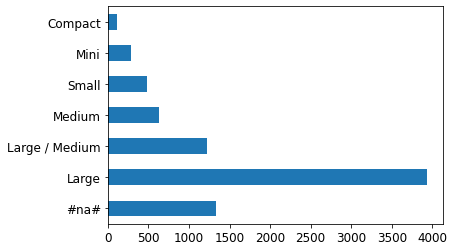

In [ ]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)
plt.show()

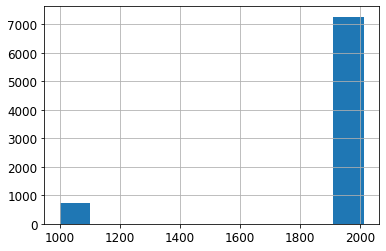

In [ ]:
ax = valid_xs_final['YearMade'].hist()

### Partial Dependence

It is to see the impact when model keeps everything and change one feature to a particular value.

e.g. For predicting a house price, when you solely change the city into London, see how much that affects prediction value in the current model built.  

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

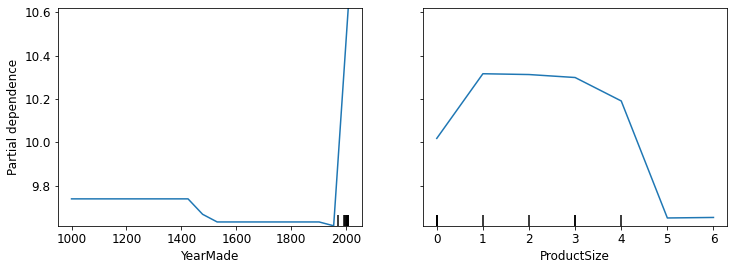

In [ ]:
fig, ax = plt.subplots(figsize = (12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade', 'ProductSize'],
                        grid_resolution = 20, ax = ax)
plt.show()

You can see the price goes up drastically when the bulldozars are made in years near 2000.

Also, when it comes to 'Product Size', 'mini' and 'compact' have much less impact than the other size type. 

### Treeinterpreter

The treeinterpreter is one such library which can help us finding out contribution of individual feature on particular prediction for tree based models of scikit-learn.

The treeinterpreter is based on a concept that when making a particular prediction decision tree or random forest follows a particular path to come to that prediction. Each node in the decision tree represent some feature and makes decisions based on the feature value in the sample. The treeinterpreter divides prediction region space into regions the same as the number of leaves present in that tree. At each internal node in a tree, the prediction value will be the average of all possible predictions in data from the path going through that node. We'll have the average value for the root node as well this way which will be the average of all predictions. This way we'll have some prediction value at each node in the tree. **The treeinterpreter uses these values to find out the contributions of each feature in prediction by finding out the difference in prediction by a particular node and the node in the path before it.** It follows the same process for the random forest where there is more than one tree and the final prediction is taken based on an average of all trees predictions.



In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
row = valid_xs_final.iloc[:5]
row

,YearMade,ProductSize,fiProductClassDesc,ModelID,Grouser_Tracks,saleElapsed,fiSecondaryDesc,Hydraulics_Flow,fiModelDesc,Enclosure,SalesID,MachineID,fiModelDescriptor,ProductGroup,Hydraulics,Drive_System,Tire_Size
22915,1000,3,48,4124,0,1.317600e+09,43,0,2301,1,1218822,1024652,0,5,1,0,0
22916,2006,0,2,24808,0,1.317859e+09,50,0,278,6,1218823,1067601,17,1,0,2,0
22917,2006,0,41,9580,2,1.317859e+09,0,3,4514,6,1218824,1010582,0,3,4,0,0
22918,2003,0,44,6270,2,1.317859e+09,0,3,4213,6,1218825,1026609,0,3,4,0,0
22919,2007,0,1,17976,0,1.317859e+09,21,0,4647,6,1218826,1032638,0,1,0,2,0


In [ ]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

The treeinterpreter has a single method named predict() which takes as input model instance and dataset for which we need explanations. It returns three arrays as output.

- The first array is **predictions for a number of samples passed to the method.**
- The second array is **bias or base value for each sample of data to which individual feature contribution will be added to generate a final prediction.**
- The third array is of size (#samples x #no_of_features) as it has the contribution of each feature for each sample which gets added to base/bias value to generate predictions.


In [ ]:
len(prediction)

5

In [ ]:
row.shape

(5, 17)

In [ ]:
contributions.shape

(5, 17)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([9.98861227]), 10.104382193832395, -0.11576992063270237)

In [ ]:
y.mean()

10.104347

In [ ]:
round(bias[0] + contributions[0].sum(), 14) == prediction[0][0]

True

adding contribution to bias equals prediction.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

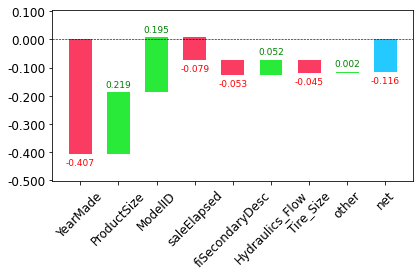

In [ ]:
# view the contributions of the features of which score is above 0.08
# the contribution on 1st bulldozer price.
waterfall(valid_xs_final.columns, contributions[0], threshold = 0.08, 
          rotation_value =45, formatting = '{:,.3f}')

For the first dataset, the model predicted the price, 9.98861227, and this prediction is the result of reflecting all features' impact (saved in contribution array) on bias (or base value).

In the plot above, the features with red bar give negative impact and ones with green positive impact.
Finally, the score on blue bar is the sum of all features' contribution.


In [ ]:
valid_xs_final.head(1)

,YearMade,ProductSize,fiProductClassDesc,ModelID,Grouser_Tracks,saleElapsed,fiSecondaryDesc,Hydraulics_Flow,fiModelDesc,Enclosure,SalesID,MachineID,fiModelDescriptor,ProductGroup,Hydraulics,Drive_System,Tire_Size
22915,1000,3,48,4124,0,1.317600e+09,43,0,2301,1,1218822,1024652,0,5,1,0,0


# Neural Network

In [ ]:
xs_final.shape

(404710, 17)

In [ ]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis = 1)
valid_xs_time = valid_xs_final.drop(time_vars, axis = 1)

In [ ]:
xs_final_time.shape

(404710, 15)

In [ ]:
m = rf(xs_final_time, y)
rmse(m, valid_xs_time, valid_y)

0.229144

In [ ]:
filt = xs['saleYear'] > 2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
# redo the preprocessing above
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory = False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered = True, inplace = True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis = 1)
valid_xs_time2 = valid_xs_final.drop('fiModelDescriptor', axis = 1)

In [ ]:
m2 = rf(xs_filt2, y_filt)
rmse(m2, xs_filt2, y_filt)

0.176935

In [ ]:
list(xs_filt2.columns)

['YearMade',
 'ProductSize',
 'fiProductClassDesc',
 'ModelID',
 'Grouser_Tracks',
 'saleElapsed',
 'fiSecondaryDesc',
 'Hydraulics_Flow',
 'fiModelDesc',
 'Enclosure',
 'ProductGroup',
 'Hydraulics',
 'Drive_System',
 'Tire_Size']

In [ ]:
# select only necessary columns for deep learning
df_nn_final = df_nn[list(xs_filt2.columns) + [dep_var]]

In [ ]:
df_nn_final.shape

(412698, 15)

In [ ]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card =9000, dep_var = dep_var) 

In [ ]:
cont_nn

['saleElapsed']

In [ ]:
cat_nn

['YearMade',
 'ProductSize',
 'fiProductClassDesc',
 'ModelID',
 'Grouser_Tracks',
 'fiSecondaryDesc',
 'Hydraulics_Flow',
 'fiModelDesc',
 'Enclosure',
 'ProductGroup',
 'Hydraulics',
 'Drive_System',
 'Tire_Size']

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

In [ ]:
# 2 layers: 1 layer with 500 neurons, 1 layer with 250 neurons
# 1 output
# mse_loss as this is the prediction on continuous value (regression)
learn = tabular_learner(dls, y_range = (8, 12), layers = [500, 250],
                        n_out = 1, loss_func = F.mse_loss)

SuggestedLRs(valley=0.00019054606673307717)

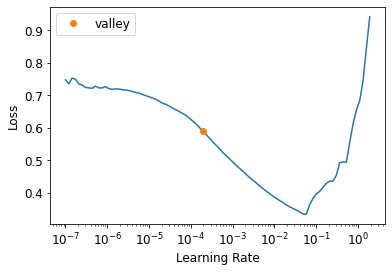

In [ ]:
# find the perfect learning rate
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063065,0.066051,00:04
1,0.054389,0.054652,00:04
2,0.047541,0.059708,00:04
3,0.043461,0.050605,00:04
4,0.040285,0.049978,00:04


In [ ]:
# final result
preds, targets = learn.get_preds()
np.sqrt(mean_squared_error(preds, targets))

0.22355674

In [ ]:
# view predictions vs actual
pd.DataFrame({'preds': preds[:10].flatten().tolist(), 
              'actual': targets[:10].flatten().tolist(),
              'diff': (preds[:10] - targets[:10]).flatten().tolist()})

,preds,actual,diff
0,10.220573,10.043249,0.177324
1,10.051466,10.085809,-0.034343
2,9.408136,9.392662,0.015474
3,9.014004,8.853665,0.160338
4,10.156481,10.126631,0.029850
5,10.593889,10.518673,0.075216
6,9.700245,9.581903,0.118341
7,9.700245,9.472705,0.227540
8,10.347047,10.275051,0.071996
9,11.067547,11.082143,-0.014596


## Export Model & Test 

In [ ]:
# export model
learn.export()

In [ ]:
test = pd.read_csv(path/'Test.csv', low_memory = False)

In [ ]:
test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,5/3/2012 0:00,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,5/10/2012 0:00,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,5/10/2012 0:00,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,5/10/2012 0:00,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metric Tons",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,5/10/2012 0:00,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horsepower",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [ ]:
test = add_datepart(test, 'saledate')

In [ ]:
dl =learn.dls.test_dl(test)

In [ ]:
# test with the original data to see if the model works
preds, _ = learn.get_preds(dl=dl)

In [ ]:
prediction = np.exp(preds).numpy()
result = pd.concat([test['SalesID'], pd.DataFrame(np.round(prediction), columns = ['Predicted_Price'])], axis = 1)
result

,SalesID,Predicted_Price
0,1227829,13466.0
1,1227844,37167.0
2,1227847,55474.0
3,1227848,99938.0
4,1227863,27145.0
...,...,...
12452,6643171,30215.0
12453,6643173,10860.0
12454,6643184,11282.0
12455,6643186,12279.0
